[](http://)We will be forecasting the number of posts published on 'Medium.' We will use a dataset that contains the URL of each post published with its timestamp. The data is available till the year 2017.

# Agenda
1. Importing Necessary Libraries
2. Data Loading, Understanding, and Cleaning
3. Simple Exponential Smoothing
4. Holt's Linear Trend Model
5. Holt Winter's Model
6. Stationarity
7. ARIMA Model
8. SARIMA Model
9. Prophet Model
10. Model Comparison

# Importing Necessary Libraries

In [2]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
from prophet import Prophet

# Machine Learning
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Loggers
import logging
logging.getLogger().setLevel(logging.ERROR)

# Data Loading, Understanding, and Cleaning
Let us read the file containing information on posts published on 'Medium'.

In [3]:
# Reading the file
df = pd.read_csv('medium_posts.csv', usecols=['published', 'url'])
print(df.shape)
df.head()

(92191, 2)


,published,url
0,2012-08-13 22:54:53.510Z,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,https://blog.medium.com/taking-a-side-on-net-n...


In [4]:
# Data types check
df.dtypes

published    object
url          object
dtype: object

In [5]:
# Checking missing values
df.isnull().sum()

published    0
url          0
dtype: int64

In [6]:
# Check for duplicates
df.duplicated().sum()

11

In [7]:
# Dropping duplicates
df_cleaned = df.drop_duplicates()

# Changing the data type of 'published' column
df_cleaned['published'] = pd.to_datetime(df_cleaned['published'])

print(df_cleaned.shape)
df_cleaned.head()

(92180, 2)


,published,url
0,2012-08-13 22:54:53.510000+00:00,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248000+00:00,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364000+00:00,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427000+00:00,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207000+00:00,https://blog.medium.com/taking-a-side-on-net-n...


In [8]:
# Investigating range of 'published' column
print(df_cleaned.published.min())
print(df_cleaned.published.max())

1970-01-01 00:00:00.001000+00:00
2017-06-27 14:48:42.850000+00:00


As Medium's public release date was August 15, 2012, let us remove data prior to this date.

In [9]:
# Preparing dataset for forecasting
df_pr = df_cleaned[df_cleaned.published>'2012-08-15']
df_pr.sort_values('published', inplace=True)
df_pr.set_index('published', inplace=True)
df_pr.head()

,url
published,
2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...
2012-08-15 00:40:10.773000+00:00,https://medium.com/@karen/this-farm-table-1cfc...
2012-08-15 00:58:25.898000+00:00,https://medium.com/@hattmodgins/lighting-strik...


In [10]:
# Resampling our data to daily timeseries
daily = df_pr.resample('D').count()
print(daily.shape)
daily.head()

(1778, 1)


,url
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4
2012-08-18 00:00:00+00:00,2
2012-08-19 00:00:00+00:00,1


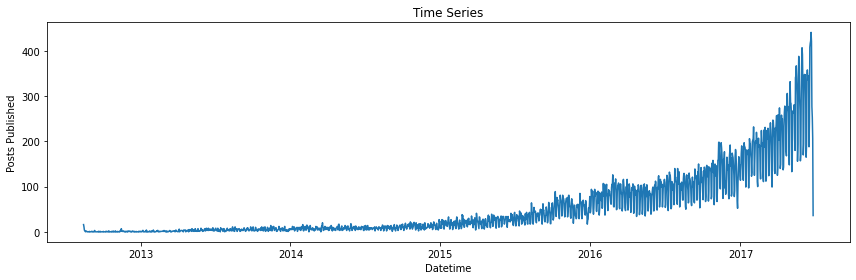

In [11]:
# Plotting the time series
plt.figure(figsize=(12, 4))
plt.plot(daily)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

As we can observe, first few years are adding noise to our timeseries considering very low number of posts per day. Moreover, these years will also not be of much help in forecasting for year 2017. Therefore, let us remove observations before 2015.

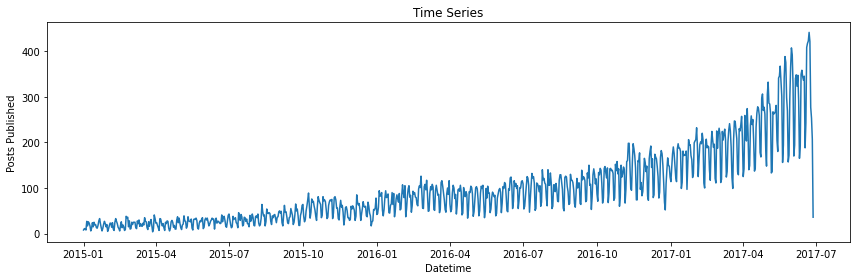

In [12]:
daily = daily.loc['2015-01-01':]

# Plotting the time series
plt.figure(figsize=(12, 4))
plt.plot(daily)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

In [13]:
# Understanding the data for time based train-test split
print(f'Start Date: {daily.index.min()}')
print(f'End Date: {daily.index.max()}')
print(f'Total Days: {len(daily)}')

Start Date: 2015-01-01 00:00:00+00:00
End Date: 2017-06-27 00:00:00+00:00
Total Days: 909


We have around 30 months data. Let us divide our daily time series into training and validation set with validation set comprising of last 4 months. Validation set will help us evaluate performance of our model.

Shape: Train=(790, 1), Validation=(119, 1)


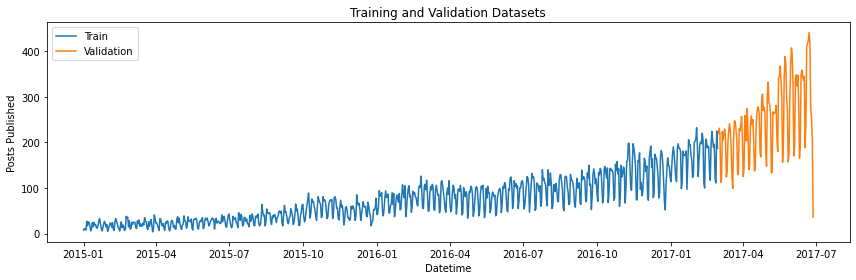

In [14]:
# Time based train-test splitting
train = daily.loc[:'2017-02-28']
valid = daily.loc['2017-03-01':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Validation')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

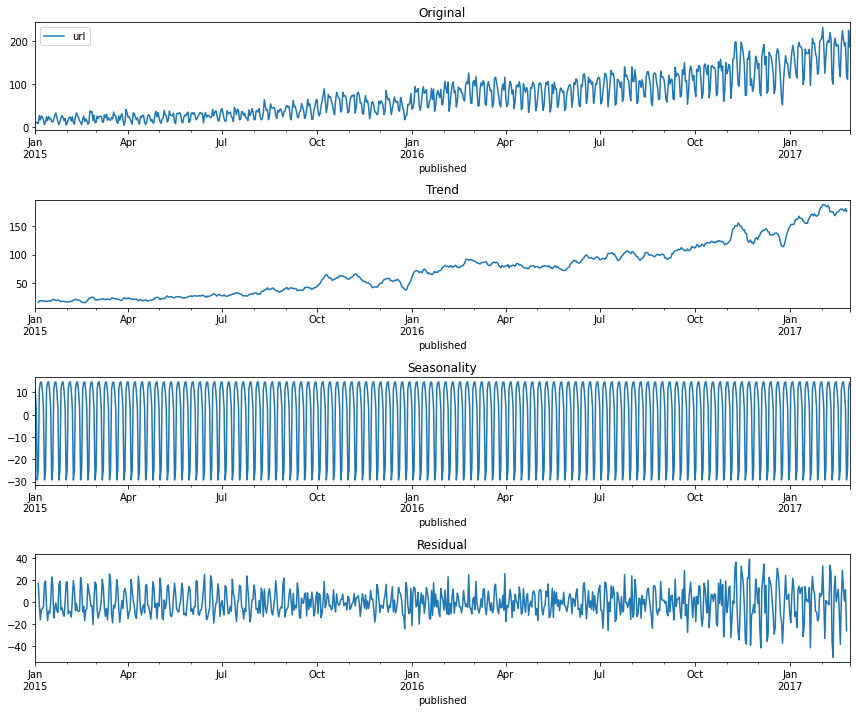

In [15]:
# Visualizing the components of our time series: Trend, Seasonality, and Noise
decomposition = sm.tsa.seasonal_decompose(train)

# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

Data can be seen to have an upward trend with weekly seasonality.

In [16]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train, label='Training')
    plt.plot(valid, label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Simple Exponential Smoothing
Let us now create a baseline model, whose performance will serve as a benchmark for the subsequent models. Simple exponential smoothing takes weighted average of the past data such that highest weightage is given to the latest data and lowest to the oldest data.

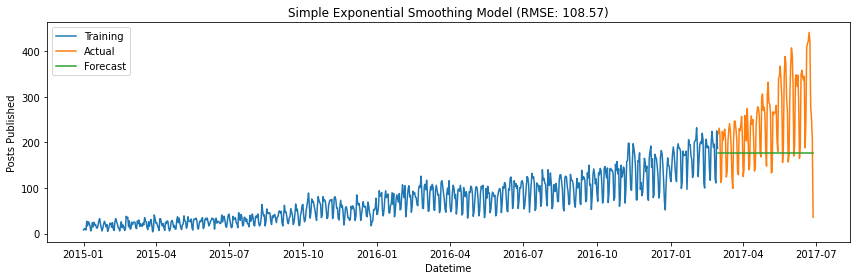

In [17]:
# Applying Simple Exponential Smoothing
ses = SimpleExpSmoothing(train).fit()
ses_pred = ses.forecast(len(valid))
ses_rmse = mean_squared_error(valid, ses_pred, squared=False)

# Plotting the predictions
plot_forecast(ses_pred, 'Simple Exponential Smoothing Model', ses_rmse)

# Holt's Linear Trend Model
Holt's linear trend model is similar to simple exponential smoothing, but it also takes into account the trend of the data.

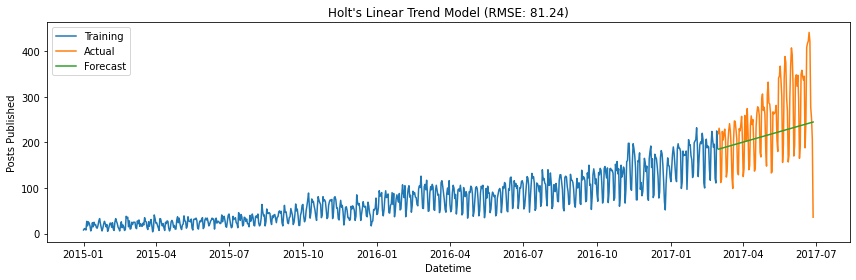

In [18]:
# Applying Holt's Linear Trend Model
hltm = Holt(train).fit()
hltm_pred = hltm.forecast(len(valid))
hltm_rmse = mean_squared_error(valid, hltm_pred, squared=False)

# Plotting the predictions
plot_forecast(hltm_pred, 'Holt\'s Linear Trend Model', hltm_rmse)

# Holt Winter's Model
Holt Winter's model is similar to simple exponential smoothing, but it also takes into account both the trend and seasonality of the data.

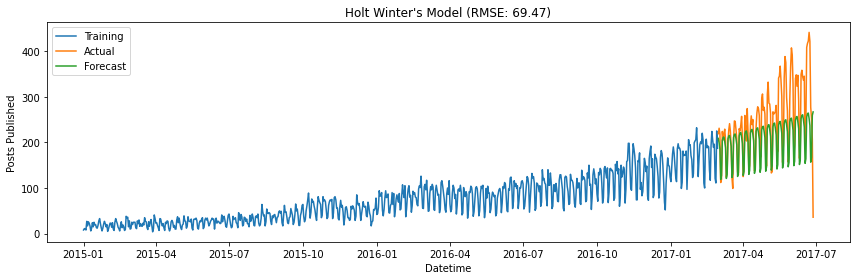

In [19]:
# Applying Holt Winter's Model
hwm = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add', use_boxcox=True, initialization_method='estimated').fit()
hwm_pred = hwm.forecast(len(valid))
hwm_rmse = mean_squared_error(valid, hwm_pred, squared=False)

# Plotting the predictions
plot_forecast(hwm_pred, 'Holt Winter\'s Model', hwm_rmse)

# Stationarity
Let us first check stationarity of the time series before applying ARIMA model.

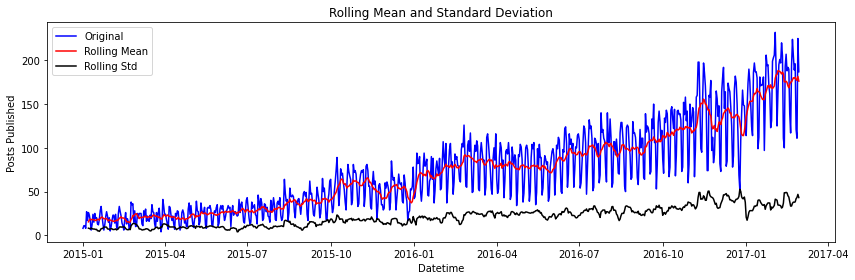

Results of Dickey-Fuller Test:
Test Statistic                   1.380068
P-Value                          0.997022
#Lags Used                      20.000000
Number of Observations Used    769.000000
Critical Value (1%)             -3.438882
Critical Value (5%)             -2.865306
Critical Value (10%)            -2.568775
dtype: float64


In [20]:
# Creating a function to check stationarity of the given data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

As the test statistic is more than the critical values, we can say that the time series is non-stationary. We can also see an upward trend in the visualization, therefore, let us first remove the trend and seasonality from the data to make it stationary.<br>
Let us begin with applying boxcox transformation to stabilize the time series. After trying different values of lambda, the best value of lambda turned out to be 0 which is nothing but log transformation.

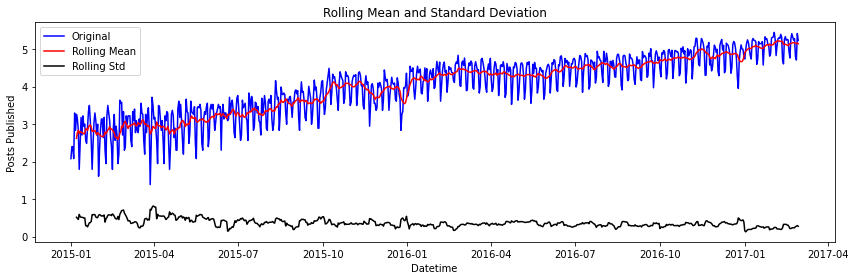

Results of Dickey-Fuller Test:
Test Statistic                  -0.611219
P-Value                          0.868427
#Lags Used                      20.000000
Number of Observations Used    769.000000
Critical Value (1%)             -3.438882
Critical Value (5%)             -2.865306
Critical Value (10%)            -2.568775
dtype: float64


In [21]:
# Performing boxcox transformation to remove trend 
train_tfm = train.copy()
lam = 0
train_tfm['url'] = boxcox(train['url'], lam)
check_stationarity(train_tfm)

Result shows increase in stationarity as p-value is reduced and test statistic is closer to the critical values than before. But, still it is non-stationary as p-value>0.05.

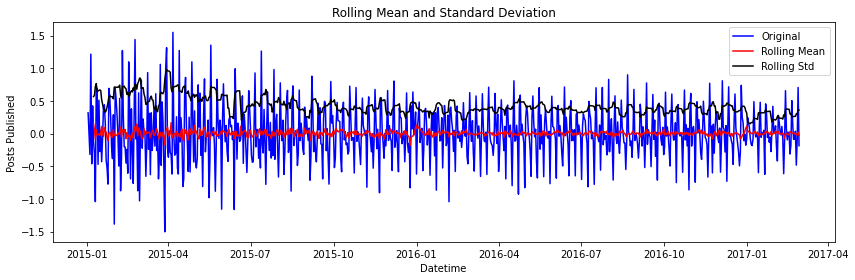

Results of Dickey-Fuller Test:
Test Statistic                -9.930119e+00
P-Value                        2.837571e-17
#Lags Used                     2.000000e+01
Number of Observations Used    7.680000e+02
Critical Value (1%)           -3.438893e+00
Critical Value (5%)           -2.865311e+00
Critical Value (10%)          -2.568778e+00
dtype: float64


In [22]:
# First Differencing of boxcox-transformed time series
train_tfm_diff = train_tfm - train_tfm.shift(1)
train_tfm_diff.dropna(inplace=True)
check_stationarity(train_tfm_diff)

The test statistic value is considerably less than the critical values and p-value is also far less than 0.05 after first differencing. Therefore, first differencing has made the time series stationary. Thus, the value of parameter d is 1.

# ARIMA Model
Let us apply Auto-ARIMA model to identify most optimal parameters for ARIMA model on the transformed time series.

In [23]:
# Auto-ARIMA on boxcox-transformed training time series without seasonality
arima = auto_arima(train_tfm, d=1, seasonal=False)
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  790
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 -48.981
Date:                Tue, 09 Aug 2022   AIC                            109.963
Time:                        09:54:44   BIC                            137.987
Sample:                             0   HQIC                           120.736
                                - 790                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2473      0.001   1771.674      0.000       1.246       1.249
ar.L2         -0.9999      0.000  -5420.227      0.000      -1.000      -1.000
ma.L1         -2.1302      0.018   -120.199      0.0

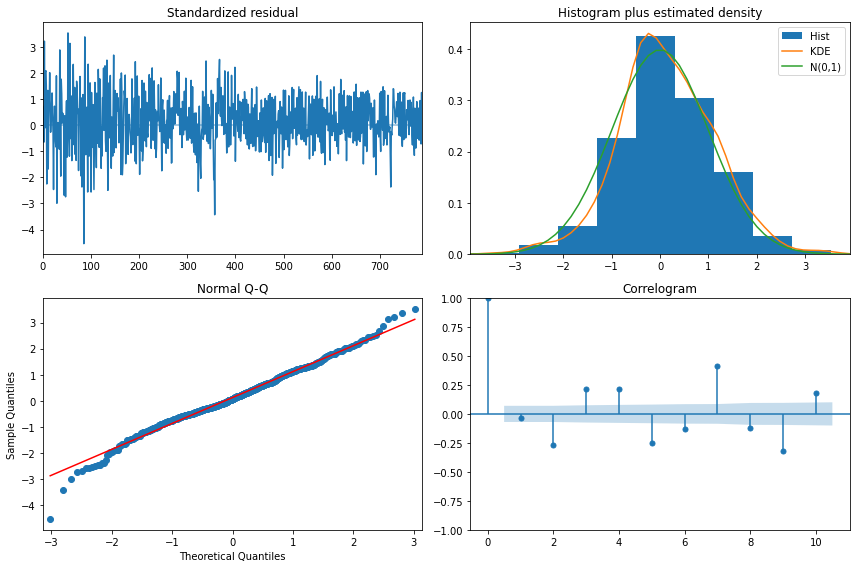

In [24]:
# Residual Plots
arima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

Above plots show that the residual errors are approximately normally distributed, but the mean is slightly deviating to the left from zero signifying bias in prediction. Moreover, correlogram indicates that some lags are still autocorrelated; especially, the lag 7 which signifies a weekly seasonality. Therefore, we'll add seasonality components to see if it accounts for these inconsistencies.
Before doing that, let us evaluate the performance of the ARIMA model on validation set.

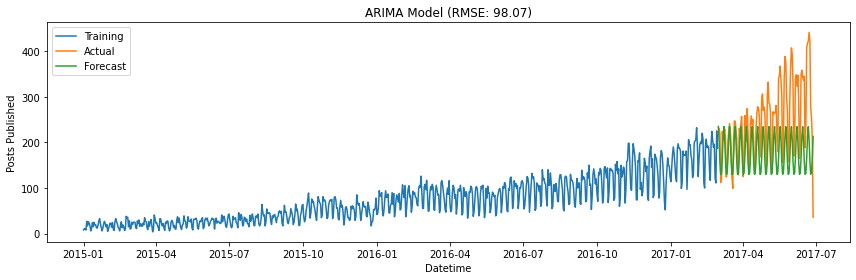

In [25]:
# Forecasting with the best model
forecast = arima.predict(len(valid))
forecast = inv_boxcox(pd.Series(forecast, index=valid.index), lam)
arima_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'ARIMA Model', arima_rmse)

# SARIMA Model
Let us determine whether adding seasonal components improves performance on our data.

In [26]:
# Auto-ARIMA on boxcox-transformed training time series with seasonality
sarima = auto_arima(train_tfm, d=1, m=7)
print(sarima.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  790
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood                 139.711
Date:                                Tue, 09 Aug 2022   AIC                           -263.423
Time:                                        09:56:38   BIC                           -226.057
Sample:                                             0   HQIC                          -249.059
                                                - 790                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.412e-06   3.84e-05      0.219      0.827   -6.69e-05    8.37e-05
ar.

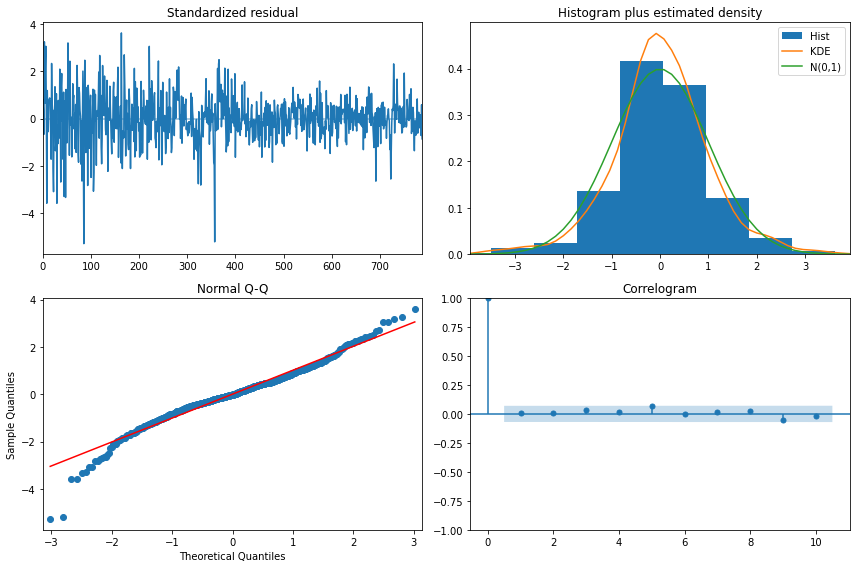

In [27]:
# Residual Plots
sarima.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [28]:
# Residual analysis
residuals = pd.Series(sarima.resid())
mean_residuals = np.mean(residuals)
print(f'Mean of Residuals = {mean_residuals}')
print(f'Skewness: {round(residuals.skew(), 2)}')

Mean of Residuals = 0.00465956251753424
Skewness: 0.84


Above plots show that residual errors are almost normally distributed with negligible positive skewness of 0.84. The mean of the distribution is also close to zero, and there is no autocorrelation with the lags. This makes the model a good fit.

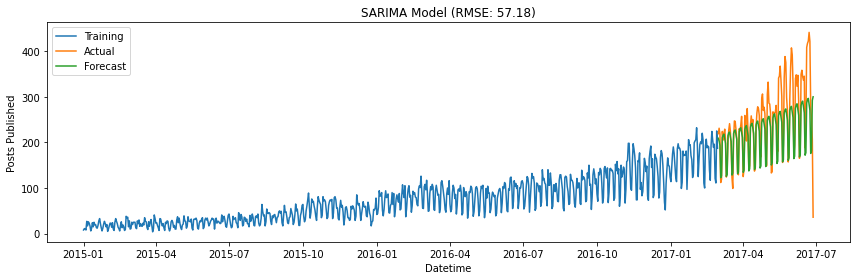

In [29]:
# Forecasting with the best model
forecast = sarima.predict(len(valid))
forecast = inv_boxcox(pd.Series(forecast, index=valid.index), lam)
sarima_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'SARIMA Model', sarima_rmse)

# Prophet Model
Let us determine how Prophet model works for our time series data.

In [30]:
# Preparing data for Prophet modelling
train_df = train.copy()
valid_df = valid.copy()
for df in [train_df, valid_df]:
    df.reset_index(inplace=True)
    df.columns = ['ds', 'y']
    # Removing timezone information from datetime object
    df['ds'] = df['ds'].apply(lambda x: x.replace(tzinfo=None))

future = valid_df.drop(columns='y')
train_df.head()

,ds,y
0,2015-01-01,8
1,2015-01-02,11
2,2015-01-03,11
3,2015-01-04,8
4,2015-01-05,27


09:56:40 - cmdstanpy - INFO - Chain [1] start processing
09:56:40 - cmdstanpy - INFO - Chain [1] done processing


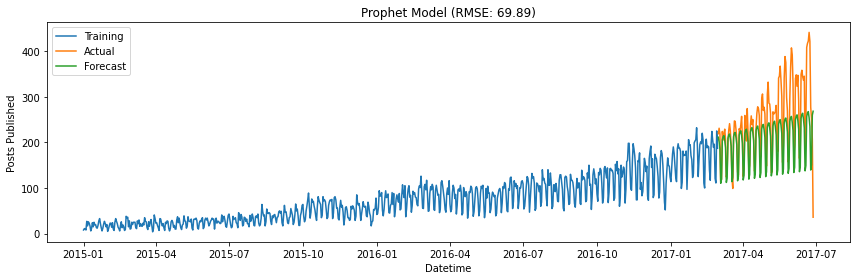

In [31]:
# Applying Prophet model
prophet = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False, seasonality_mode='multiplicative')
prophet.fit(train_df)
predictions = prophet.predict(future)
forecast = predictions[['ds', 'yhat']]
forecast.set_index('ds', inplace = True)
prophet_rmse = mean_squared_error(valid, forecast, squared=False)

# Plotting the forecast
plot_forecast(forecast, 'Prophet Model', prophet_rmse)

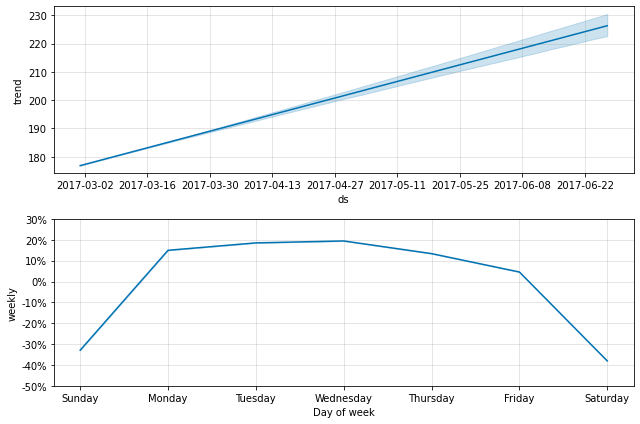

In [32]:
# The components of the model
fig = prophet.plot_components(predictions)

# Model Comparison
Let us now compare performance of all the models we applied so far.

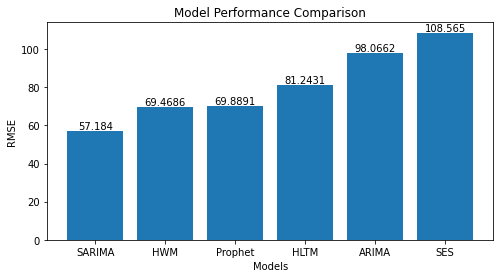

In [33]:
# Comparing Model Performances
perf = pd.DataFrame({'Model': ['SES', 'HLTM', 'HWM', 'ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [ses_rmse, hltm_rmse, hwm_rmse, arima_rmse, sarima_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)

# Plotting model performances
plt.figure(figsize=(8, 4))
vbar = plt.bar(perf.Model, perf.RMSE)
plt.bar_label(vbar)
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.show()

The SARIMA model resulted in the least RMSE value for our time series.